In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load datasets
attr_data = pd.read_csv('Attribute dataset.csv')
dress_sales = pd.read_csv("DressSales.csv")

In [3]:
# Data Preprocessing
def preprocess_attribute_data(df):
    df['Size'].replace({'M': "Medium", 'L': 'Large', 'XL': 'Extra Large', 'free': 'Free', 'S': 'Small', 's': 'Small', 'small': 'Small'}, inplace=True)
    return df

In [4]:
def preprocess_sales_data(df):
    df.replace('removed', np.NaN, inplace=True)
    df.replace('Removed', np.NaN, inplace=True)
    df.replace('Orders', np.NaN, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

attr_data = preprocess_attribute_data(attr_data)
dress_sales = preprocess_sales_data(dress_sales)

In [5]:
# Drop columns with more than 40% missing values
threshold = 0.4
dress_sales.dropna(thresh=int(threshold * len(dress_sales)), axis=1, inplace=True)

In [6]:
# Calculate and add season columns
seasons = {
    'Summer': ['29-08-2013', '31-08-2013', '09-06-2013', '09-08-2013', '10-06-2013'],
    'Autumn': ['09-10-2013', '14-09-2013', '16-09-2013', '18-09-2013', '20-09-2013', '22-09-2013', '24-09-2013', '28-09-2013'],
    'Winter': ['09-02-2013', '10-12-2013'],
    'Spring': ['09-04-2013']
}

for season, dates in seasons.items():
    dress_sales[season] = dress_sales[dates].sum(axis=1)


In [7]:
# Merge attribute and sales data
data = pd.merge(attr_data, dress_sales, on='Dress_ID')
data.drop(columns=dress_sales.columns.difference(['Dress_ID', 'Summer', 'Autumn', 'Winter', 'Spring']), inplace=True)


In [8]:
# Fix spelling issues
data['Season'].replace({'Automn': "Autumn", 'spring': "Spring", 'winter': "Winter"}, inplace=True)

# Calculate total sales
data['TotalSales'] = data[['Summer', 'Winter', 'Autumn', 'Spring']].sum(axis=1)

# Group "Style" categories into "Others" with less than 50000 sales
style_sales = data.groupby('Style')['TotalSales'].sum()
styles_to_replace = style_sales[style_sales < 50000].index

In [9]:
data['Style'].replace(styles_to_replace, 'Others', inplace=True)

# Handling missing values
columns_with_missing_values = ['Price', 'Season', 'NeckLine', 'SleeveLength', 'Material', 'FabricType', 'Decoration', 'Pattern Type', 'Winter', 'Autumn', 'TotalSales']
imputer = SimpleImputer(strategy='most_frequent')
data[columns_with_missing_values] = imputer.fit_transform(data[columns_with_missing_values])

# Define features and target for regression
X = data.drop(columns=['Dress_ID', 'Recommendation', 'TotalSales'])
y = data['TotalSales']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines for numerical and categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Regression Results for Linear Regression:

MAE: 648.6809232159134
MSE: 1132415.3978387418
R2: 0.9829130934294108



Regression Results for Random Forest:

MAE: 403.4116666666667
MSE: 555919.3430062501
R2: 0.9916117867234407



Regression Results for SVR:

MAE: 4005.892322685085
MSE: 71308289.8464623
R2: -0.07596389861920794



Performing Grid Search for Random Forest...


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters for Random Forest: {'regressor__max_depth': 20, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best cross-validation R2 score for Random Forest: 0.9249365648480147


Performing Grid Search for SVR...
Best parameters for SVR: {'regressor__C': 100, 'regressor__epsilon': 0.1, 'regressor__gamma': 'scale'}
Best cross-validation R2 score for SVR: 0.9804412834923601


Regression Results for Linear Regression:

MAE: 648.6809232159134
MSE: 1132415.3978387418
R2: 0.9829130934294108



Regression Results for Random Forest:

MAE: 445.1707974987976
MSE: 808526.9427580038
R2: 0.987800215047343



Regression Results for SVR:

MAE: 679.0309374448542
MSE: 1817290.831624837
R2: 0.972579074153508



Summary for Linear Regression:

Mean Absolute Error (MAE): 648.6809232159134
Mean Squared Error (MSE): 1132415.3978387418
R2 Score: 0.9829130934294108



Summary for Random Forest:

Mean Absolute Error (MA

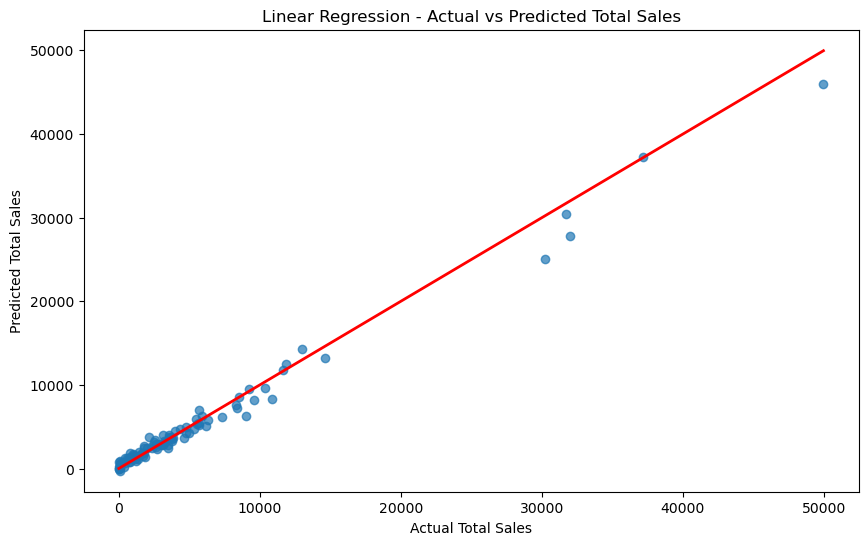

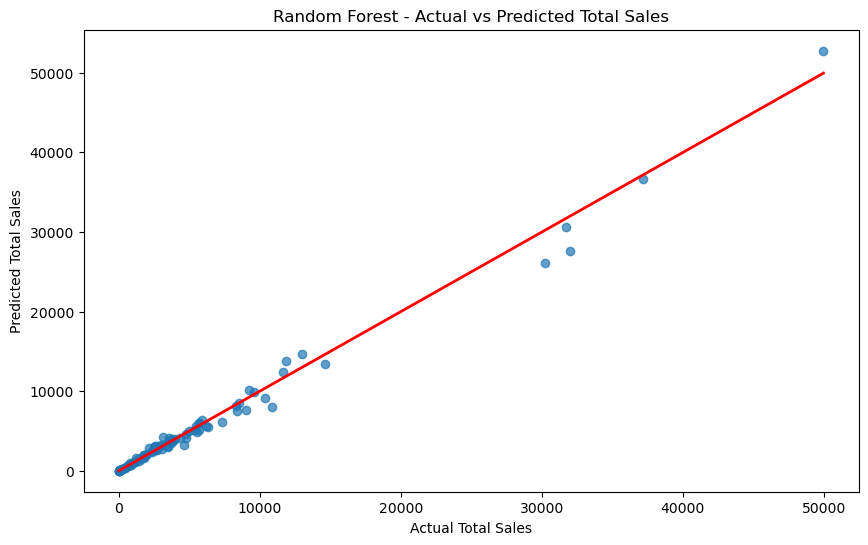

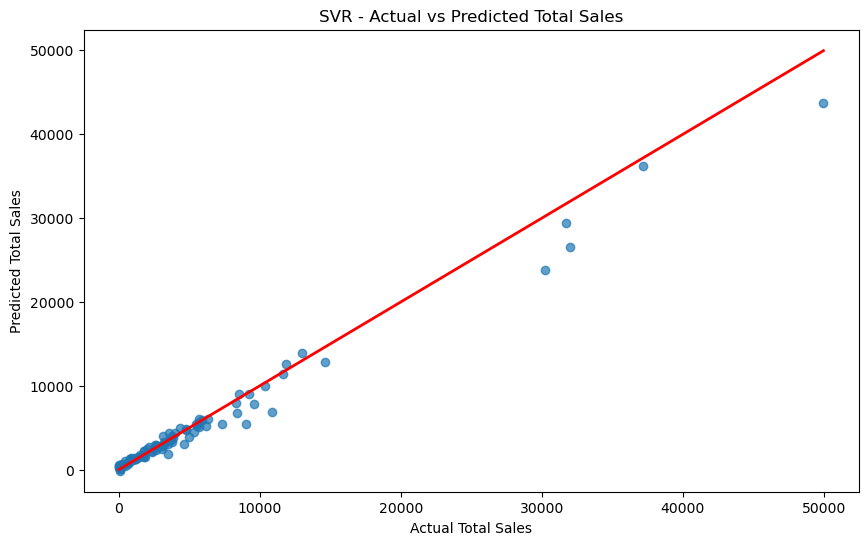

In [13]:
# Define regression models and parameter grids for hyperparameter tuning
reg_models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth': [10, 20, 30, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }),
    'SVR': (SVR(kernel='linear'), {
        'regressor__C': [0.1, 1, 10, 100],
        'regressor__epsilon': [0.1, 0.2, 0.5, 1],
        'regressor__gamma': ['scale', 'auto']
    })
}

# Function to evaluate models
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f'Regression Results for {model_name}:\n')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'R2: {r2_score(y_test, y_pred)}\n')
    print('\n' + '='*60 + '\n')

# Evaluate all models
for model_name, (model, _) in reg_models.items():
    evaluate_model(model_name, model, X_train, y_train, X_test, y_test)

# Function to perform grid search
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Perform grid search for each model with parameters
best_models = {}
for model_name, (model, param_grid) in reg_models.items():
    if param_grid:
        print(f"Performing Grid Search for {model_name}...")
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
        best_model = perform_grid_search(pipeline, param_grid, X_train, y_train)
        best_models[model_name] = best_model
        print(f"Best parameters for {model_name}: {best_model.best_params_}")
        print(f"Best cross-validation R2 score for {model_name}: {best_model.best_score_}")
        print('\n' + '='*60 + '\n')
    else:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
        pipeline.fit(X_train, y_train)
        best_models[model_name] = pipeline

# Evaluate the best models on the test set
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    print(f'Regression Results for {model_name}:\n')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'R2: {r2_score(y_test, y_pred)}\n')
    print('\n' + '='*60 + '\n')

# Summary of findings
def summarize_results(models, X_test, y_test):
    summary = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        summary[model_name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }
    return summary

# Get summary of best models
best_model_summary = summarize_results(best_models, X_test, y_test)
for model_name, metrics in best_model_summary.items():
    print(f"Summary for {model_name}:\n")
    print(f"Mean Absolute Error (MAE): {metrics['MAE']}")
    print(f"Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"R2 Score: {metrics['R2']}\n")
    print('\n' + '='*60 + '\n')

# Visualizations of the results
def plot_results(y_test, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.7)
    plt.xlabel('Actual Total Sales')
    plt.ylabel('Predicted Total Sales')
    plt.title(f'{model_name} - Actual vs Predicted Total Sales')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.show()

# Plot results for the best models
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    plot_results(y_test, y_pred, model_name)